<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Загрузим все необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt 
plt.style.use('seaborn-pastel')
import seaborn as sns 
import numpy as np 

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import f1_score

from time import time
from tqdm import tqdm

pd.options.display.max_columns = None # полностью отображаем столбцы

Подгрузим необходимые файлы для английской библиотеки лемматизатора:

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cool-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cool-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Подгрузим данные:

In [3]:
try:
    df = pd.read_csv('D:/DS/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


От лишних символов текст очистят регулярные выражения.

Это инструмент для поиска слова или числа по шаблону (pattern). Он определяет, из каких частей состоит строка и какие в них символы. Например, нужно найти все даты в таком формате записи: 02.02.2020. Их шаблон — это два числа, точка, два числа, точка, четыре числа.

Шаблон для email-адреса такой: строка на латинице, символ @, строка на латинице, точка, строка на латинице.

Для работы с регулярными выражениями в Python есть встроенный модуль `re` (сокр. от regular expressions).
Создадим функцию, которая очистит текст для будущей лемматизации:

In [4]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text.lower()) # преобразовываем и переводим в нижний регистр
    retext = text.split() 
    text = " ".join(retext)
    return text

Прежде чем извлечь признаки из текста, упростим его.

Рассмотрим этапы предобработки текста:

1. Токенизация (англ. tokenization) — разбиение текста на токены: отдельные фразы, слова, символы.
2. Лемматизация (англ. lemmatization) — приведение слова к начальной форме (лемме).

Создадим функцию для тоекнизации и лемматизации текста:

In [5]:
def lemmetize(words):
    lemmatizer = WordNetLemmatizer() 
    text = [] # создаём список для заполнения
    tokens = word_tokenize(words) # токенизируем текст
    for token in tokens: # лемматизируем каждый токен
        lemmetized_word = lemmatizer.lemmatize(token) 
        text.append(lemmetized_word)
    sentence = " ".join(text) # объединяем в текст обратно
    return sentence

Воспользуемся полученными функциями и посмотрим результат:

In [6]:
df['lemm_text'] = df['text'].apply(clear_text)
df['lemm_text'] = df['lemm_text'].apply(lemmetize)

df['lemm_text']

0         explanation why the edits made under my userna...
1         d aww he match this background colour i m seem...
2         hey man i m really not trying to edit war it s...
3         more i can t make any real suggestion on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm there no actual article for prosti...
159569    and it look like it wa actually you who put on...
159570    and i really don t think you understand i came...
Name: lemm_text, Length: 159571, dtype: object

Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на корпусе (англ. corpus). Это набор текстов, в котором эмоции и ключевые слова уже размечены.

Разделим датасет на тестовую и тренировочную выборку, размер тестовой выборки - 20% от общих данных:

In [7]:
train_features, test_features, train_target, test_target = train_test_split(
    df.drop('toxic', axis=1),
    df['toxic'],
    test_size=0.2,
    random_state=12345,
    stratify=df['toxic'] # стратифицируем текст, чтобы выборки были более сбалансированы
)

# вытаскиваем корпусы
corpus_train = train_features['lemm_text']
corpus_test = test_features['lemm_text']
corpus_train

24614     actually moving it here would be xenophrenic s...
91768     bomb awwwaaaayyyyy wikipedia featured article ...
136895    relation wa this dale robert any relation to t...
1707      in addition even assuming that your condition ...
62980     big brother please stop changing the day in th...
                                ...                        
29011     i give up the user who ha nominated it for del...
23785                         preach you are not consistent
101592    not how the level scaling work for example if ...
64359     thanks yulia for your intelligence i saw your ...
23091                      greaser film you re an idiot bye
Name: lemm_text, Length: 127656, dtype: object

Мешок слов учитывает частоту употребления слов. Оценка важности слова определяется величиной `TF-IDF` (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»). 

То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Воспользуемся `TfidfVectorizer` и, чтобы почистить мешок слов, добавим в него стоп-слова:

In [8]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # подгружаем счетчик и задаём стоп-слова
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # обучаем и трансформируем
tf_idf_test = count_tf_idf.transform(corpus_test) # трансформируем тестовую без обучения

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (127656, 138538)
Размер матрицы: (31915, 138538)


Обработка данных выполнена, TF-IDF подсчитано, можно приступить к обучению модели:

## Обучение

Воспользуемся несколькими библиотеками и моделями машинного обучения:

1. Линейная регрессия
2. Дерево решений
3. Случайный лес 
4. Градиентный бустинг

Такими библиотеками, как:

* `sklearn`
* `XGBoost`
* `LightGBM`

Для подбора параметров деревянных моделей будем использовать `RandomizedSearchSV`, чтобы ускорить вычисления.

Создадим функцию, которая обучит и вернет модель, а так же заполнит таблицу для анализа метрик:

In [9]:
# создаём таблицу для анализа
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[]})
all_models = []

# создаём функцию для подбора параметров
def train_model(model, parameters):
    
    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1', 
        n_jobs=-1,
        cv=4, 
        verbose=2
    )
    
    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(tf_idf_train, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))
    
    # высчитаем метрики
    f1 = model_random.best_score_
    f1_on_train = f1_score(train_target, model_random.predict(tf_idf_train))
    
    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)

    # заполним все таблицы    
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train])
    analisys.loc[len(analisys.index)] = row
    
    return model_random

**Логистическая регрессия**

In [10]:
# зададим рандомные параметры

ran_lr = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
}

logr = LogisticRegression(max_iter=1000)

lr_random = train_model(logr, ran_lr) # обучим и сохраним значения

Fitting 4 folds for each of 8 candidates, totalling 32 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.74534814        nan 0.6204799         nan 0.70877925
        nan 0.64631675]
  warnings.warn(


RandomizedSearchCV подбирал параметры 78.47 секунд
Лучшие параметры: {'penalty': 'l2', 'class_weight': 'balanced'}
F1 обученной модели: 0.7453481366184241
F1 на тренировочной выборке: 0.8283297395919721


**Дерево решений**

In [11]:
# зададим рандомные параметры

ran_grid_tree = {
    "max_depth": list(range(45, 56))
}

dtr = DecisionTreeClassifier()

dtr_random = train_model(dtr, ran_grid_tree) # обучим и сохраним значения

Fitting 4 folds for each of 10 candidates, totalling 40 fits
RandomizedSearchCV подбирал параметры 153.47 секунд
Лучшие параметры: {'max_depth': 54}
F1 обученной модели: 0.7088247544692137
F1 на тренировочной выборке: 0.8220526482142051


**Случайный лес**

In [12]:
# зададим рандомные параметры

ran_grid_forest = {
    'max_depth': [300, 310],
    'n_estimators': [12, 14],
}

rfc = RandomForestClassifier(n_jobs=-1)

rfc_random = train_model(rfc, ran_grid_forest) # обучим и сохраним значения

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 139.99 секунд
Лучшие параметры: {'n_estimators': 14, 'max_depth': 310}
F1 обученной модели: 0.6176143661779536
F1 на тренировочной выборке: 0.913085324517722


**LightGBM**

In [13]:
rand_lgbm_param = {
    'max_depth': [15, 25],
    'learning_rate': [0.1, 0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 118.23 секунд
Лучшие параметры: {'max_depth': 25, 'learning_rate': 0.3}
F1 обученной модели: 0.763426361201411
F1 на тренировочной выборке: 0.8566945163068832


**XGBoost**

In [14]:
rand_xgb_param = {
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.5, 1.0]
}

xb = xgb.XGBClassifier(booster='gbtree', 
                      use_rmm=True,
                      n_jobs=-1)

xb_random = train_model(xb, rand_xgb_param)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


D:\programms\anaconda\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 408.81 секунд
Лучшие параметры: {'max_depth': 9, 'learning_rate': 0.5}
F1 обученной модели: 0.7549245397701778
F1 на тренировочной выборке: 0.8532667212196907


**Анализ полученных метрик и выбор модели:**

,model,F1_model,F1_on_train,names
0,LogisticRegression(max_iter=1000),0.745348,0.828330,LogisticRegression
1,DecisionTreeClassifier(),0.708825,0.822053,DecisionTree
2,RandomForestClassifier(n_jobs=-1),0.617614,0.913085,RandomForest
3,LGBMClassifier(),0.763426,0.856695,LightGBM
4,"XGBClassifier(base_score=None, booster='gbtree...",0.754925,0.853267,XGBoost


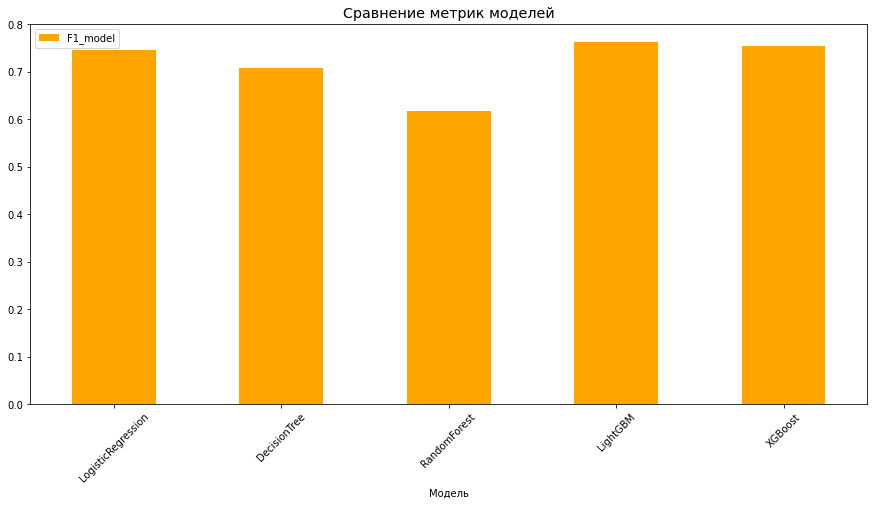

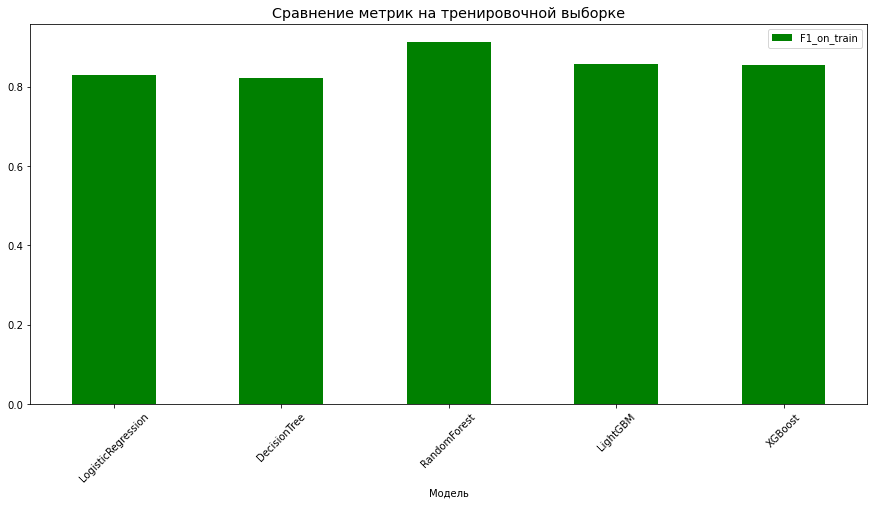

In [15]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

**Общий вывод:**

Исходя из полученных метрик качества моделей, лучшая модель на RandomizedSearchCV - LightGBM c параметрами `max_depth`: 25, `learning_rate`: 0.3. На тренировочной выборке, лучшую метрику показывает модель Случайного леса, но и худшую на подборе параметров, то есть модель переобучена и не показывает нужных метрик.

Для финальных результатов и проверки качества на тестовой выборке воспользуемся моделью LightGBM, которая уже обучена.

## Выводы

Подсчитаем метрики на тестовой выборке:

In [16]:
predicted = xb_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_target, predicted))

F1 лучшей модели на тестовой выборке: 0.7555399226169539


**Вывод:**

Необходимые метрики достигнуты, модель LightGBM, обученная через RandomizedSearchCV, предсказывает с необходимой метрикой: F1 > 0.75. 